<a href="https://colab.research.google.com/github/tnc-br/ddf-isoscapes/blob/new_kl/dnn/kriging_variational_ensemble_ablated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational model

Find the mean/variance of O18 ratios (as well as N15 and C13 in the future) at a particular lat/lon across Brazil. At the bottom of the colab, train and evaluate 4 different versions of the model with different data partitioning strategies.

In [14]:
from collections import defaultdict
import math
import numpy as np
import pandas as pd
import datetime
import os
from typing import List, Tuple, Dict
from dataclasses import dataclass

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from matplotlib import pyplot as plt
from tensorflow.python.ops import math_ops
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.compose import ColumnTransformer

#@title Debugging
# See https://zohaib.me/debugging-in-google-collab-notebook/ for tips,
# as well as docs for pdb and ipdb.
DEBUG = False #@param {type:"boolean"}
USE_LOCAL_DRIVE = False #@param {type:"boolean"}
LOCAL_DIR = "/usr/local/google/home/ruru/Downloads/amazon_sample_data-20230712T203059Z-001" #@param
GDRIVE_DIR = "MyDrive/amazon_rainforest_files/" #@param
FP_ROOT = LOCAL_DIR

RASTER_BASE = "/MyDrive/amazon_rainforest_files/amazon_rasters/" #@param
MODEL_SAVE_LOCATION = "/MyDrive/amazon_rainforest_files/variational/model/" #@param
OUTPUT_RASTER_BASE = "/MyDrive/amazon_rainforest_files/variational/rasters/" #@param

def get_model_save_location(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, GDRIVE_DIR,'variational/model', filename)

def get_raster_path_from_params(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, GDRIVE_DIR, 'amazon_rasters', filename)

def get_output_raster_path_from_params(filename) -> str:
  root = '' if USE_LOCAL_DRIVE else '/content/drive'
  return os.path.join(root, GDRIVE_DIR, 'amazon_rasters', filename)

# Access data stored on Google Drive if not reading data locally.
if not USE_LOCAL_DRIVE:
  from google.colab import drive
  drive.mount('/content/drive')
  global FP_ROOT
  FP_ROOT = os.path.join('/content/drive', GDRIVE_DIR)

if DEBUG:
    %pip install -Uqq ipdb
    import ipdb
    %pdb on

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preparation


In [13]:
def load_dataset(path: str):
  df = pd.read_csv(path, encoding="ISO-8859-1", sep=',')
  df = df[df['d18O_cel_variance'].notna()]

  # Family is too sparse. Too many families exist in validation/test that won't
  # exist in train, so drop it.
  X = df.drop(["d18O_cel_mean", "d18O_cel_variance", "Code", "Family",
               'predkrig_br_lat_ISORG', 'Origin',
               'Iso_Oxi_Stack_mean_TERZER',
               'isoscape_fullmodel_d18O_prec_REGRESSION', "Unnamed: 0"], axis=1)
  Y = df[["d18O_cel_mean", "d18O_cel_variance"]]
  return X, Y

Standardization

In [15]:
@dataclass
class FeaturesToLabels:
  def __init__(self, X: pd.DataFrame, Y: pd.DataFrame):
    self.X = X
    self.Y = Y

  def as_tuple(self):
    return (self.X, self.Y)


def create_feature_scaler(X: pd.DataFrame) -> ColumnTransformer:
  columns_to_normalize = ['lat', 'long', 'VPD', 'RH', 'PET', 'DEM', 'PA',
                          'Mean Annual Temperature',
                          'Mean Annual Precipitation',
                          'ordinary_kriging_linear_d18O_predicted_variance',
                          'ordinary_kriging_linear_d18O_predicted_mean']
  columns_to_standardize = []
  feature_scaler = ColumnTransformer([
      ('feature_normalizer', MinMaxScaler(), columns_to_normalize),
      ('feature_standardizer', StandardScaler(), columns_to_standardize)],
      remainder='passthrough')
  feature_scaler.fit(X)
  return feature_scaler

def create_label_scaler(Y: pd.DataFrame) -> ColumnTransformer:
  label_scaler = ColumnTransformer([
      ('mean_std_scaler', StandardScaler(), ['d18O_cel_mean']),
      ('var_minmax_scaler', MinMaxScaler(), ['d18O_cel_variance'])],
      remainder='passthrough')
  label_scaler.fit(Y)
  return label_scaler

def scale(X: pd.DataFrame, Y: pd.DataFrame, feature_scaler, label_scaler):
  # transform() outputs numpy arrays :(  need to convert back to DataFrame.
  X_standardized = pd.DataFrame(feature_scaler.transform(X),
                        index=X.index, columns=X.columns)
  # Y_standardized = pd.DataFrame(label_scaler.transform(Y),
  #                                     index=Y.index, columns=Y.columns)
  # FOR NOW, DO NOT SCALE Y.
  return FeaturesToLabels(X_standardized, Y)

In [ ]:
# Just a class organization, holds each scaled dataset and the scaler used.
# Useful for unscaling predictions.
@dataclass
class ScaledPartitions():
  def __init__(self,
               feature_scaler: ColumnTransformer,
               label_scaler: ColumnTransformer,
               train: FeaturesToLabels, val: FeaturesToLabels,
               test: FeaturesToLabels):
    self.feature_scaler = feature_scaler
    self.label_scaler = label_scaler
    self.train = train
    self.val = val
    self.test = test


def load_and_scale(config: Dict) -> ScaledPartitions:
  X_train, Y_train = load_dataset(config['TRAIN'])
  X_val, Y_val = load_dataset(config['VALIDATION'])
  X_test, Y_test = load_dataset(config['TEST'])

  feature_scaler = create_feature_scaler(X_train)
  label_scaler = create_label_scaler(Y_train)
  train = scale(X_train, Y_train, feature_scaler, label_scaler)
  val = scale(X_val, Y_val, feature_scaler, label_scaler)
  test = scale(X_test, Y_test, feature_scaler, label_scaler)
  return ScaledPartitions(feature_scaler, label_scaler, train, val, test)


# Model Definition



The KL Loss function:

In [16]:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
def kl_divergence(real, predicted):
    real_mean = real[:,0:1]
    real_std = tf.math.sqrt(real[:,1:2])

    predicted_mean = predicted[:,0:1]
    predicted_std = tf.math.sqrt(predicted[:,1:2])

    kl_loss = -0.5 + tf.math.log(predicted_std/real_std) + \
     (tf.square(real_std) + tf.square(real_mean - predicted_mean))/ \
     (2*tf.square(predicted_std))

    return tf.math.reduce_mean(kl_loss)

Test the loss function:

In [17]:
import pytest

test_real = tf.convert_to_tensor(np.array([[1, 0.02]]))
test_pred = tf.convert_to_tensor(np.array([[0.98, 0.021]]))

# https://screenshot.googleplex.com/5WM9dinAbhR26ZS
assert float(kl_divergence(test_real, test_pred)) == pytest.approx(0.0101094, 1e-5)

test_neg_real = tf.convert_to_tensor(np.array([[32.32, 0.0344]]))
test_neg_pred = tf.convert_to_tensor(np.array([[32.01, -0.322]]))

# Negative variance causes NaN
assert tf.math.is_nan(kl_divergence(test_neg_real, test_neg_pred))

# Calculated manually by computing the result of this equation in wolfram alpha:
# log(σ2/σ1) + ( σ1^2+(μ1−μ2)^2 ) / 2* σ^2   − 1/2
test_real_2d = tf.convert_to_tensor(np.array(
    [[1.00, 0.020],
     [1.01, 0.042]]))
test_pred_2d = tf.convert_to_tensor(np.array(
    [[0.98, 0.021],
     [0.99, 0.012]]))

# Should reduce to the average loss of all rows.
assert float(kl_divergence(test_real_2d, test_pred_2d)) == pytest.approx(
    sum([0.0101094, 0.6402851])/2, 1e-5)

Model definition

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

def get_early_stopping_callback():
  return EarlyStopping(monitor='val_loss', patience=1000, min_delta=0.001,
                       verbose=1, restore_best_weights=True, start_from_epoch=10)

tf.keras.utils.set_random_seed(18731)

# I was experimenting with models that took longer to train, and used this
# checkpointing callback to periodically save the model. It's optional.
def get_checkpoint_callback(model_file):
  return ModelCheckpoint(
      get_model_save_location(model_file),
      monitor='val_loss', verbose=0, save_best_only=True, mode='min')

def train_or_update_variational_model(
        sp: ScaledPartitions,
        hidden_layers: List[int],
        epochs: int,
        batch_size: int,
        lr: float,
        model_file=None,
        use_checkpoint=False):
  callbacks_list = [get_early_stopping_callback(),
                    get_checkpoint_callback(model_file)]
  if not use_checkpoint:
    inputs = keras.Input(shape=(sp.train.X.shape[1],))
    x = inputs
    for layer_size in hidden_layers:
      x = keras.layers.Dense(
          layer_size, activation='relu')(x)
    mean_output = keras.layers.Dense(
        1, name='mean_output')(x)

    # We can not have negative variance. Apply very little variance.
    var_output = keras.layers.Dense(
        1, name='var_output')(x)

    # Invert the normalization on our outputs
    mean_scaler = sp.label_scaler.named_transformers_['mean_std_scaler']
    untransformed_mean = mean_output * mean_scaler.var_ + mean_scaler.mean_

    var_scaler = sp.label_scaler.named_transformers_['var_minmax_scaler']
    untransformed_var = var_output * var_scaler.scale_ + var_scaler.min_

    untransformed_abs_var = keras.layers.Lambda(lambda t: tf.abs(t))(untransformed_var)

    # Output mean, |variance| tuples.
    outputs = keras.layers.concatenate([untransformed_mean, untransformed_abs_var])
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Later epochs seem to benefit from lower learning rate... but it takes
    # a while to get there.
    decay = keras.optimizers.schedules.ExponentialDecay(
       lr, decay_steps=100, decay_rate=0.5, staircase=True)

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=kl_divergence)
    model.summary()
  else:
    model = keras.models.load_model(
        get_model_save_location(model_file),
        custom_objects={"kl_divergence": kl_divergence})
  history = model.fit(sp.train.X, sp.train.Y, verbose=0, epochs=epochs, batch_size=batch_size,
                      validation_data=sp.val.as_tuple(),
                      shuffle=True, callbacks=callbacks_list)
  return history, model

In [23]:
from sklearn.metrics import mean_squared_error

def render_plot_loss(history, name):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title(name + ' model loss')
  plt.ylabel('loss')
  plt.yscale("log")
  plt.ylim((0, 10))
  plt.xlabel('epoch')
  plt.legend(['loss', 'val_loss'], loc='upper left')
  plt.show()

def destandardize(sd: ScaledPartitions, df: pd.DataFrame):
  means = pd.DataFrame(
      sd.label_scaler.named_transformers_['var_std_scaler'].inverse_transform(df[['d18O_cel_mean']]),
      index=df.index, columns=['d18O_cel_mean'])
  vars = df['d18O_cel_variance']
  return means.join(vars)

def train_and_evaluate(sp: ScaledPartitions, run_id: str, training_batch_size=5):
  print("==================")
  print(run_id)
  history, model = train_or_update_variational_model(
      sp, hidden_layers=[20, 20], epochs=5000, batch_size=training_batch_size,
      lr=0.00002, model_file=run_id+".h5", use_checkpoint=False)
  render_plot_loss(history, run_id+" kl_loss")
  model.save(get_model_save_location(run_id+".h5"), save_format="h5")

  best_epoch_index = history.history['val_loss'].index(min(history.history['val_loss']))
  print('Val loss:', history.history['val_loss'][best_epoch_index])
  print('Train loss:', history.history['loss'][best_epoch_index])
  print('Test loss:', model.evaluate(x=sp.test.X, y=sp.test.Y, verbose=0))

  test_predictions = model.predict_on_batch(sp.test.X)
  test_predictions = pd.DataFrame(test_predictions, columns=['d18O_cel_mean', 'd18O_cel_variance'])
  test_rmse = np.sqrt(mean_squared_error(sp.test.Y['d18O_cel_mean'], test_predictions['d18O_cel_mean']))
  print("dO18 Test RMSE: "+ str(test_rmse))

  val_predictions = model.predict_on_batch(sp.val.X)
  val_predictions = pd.DataFrame(val_predictions, columns=['d18O_cel_mean', 'd18O_cel_variance'])
  val_rmse = np.sqrt(mean_squared_error(sp.val.Y['d18O_cel_mean'], val_predictions['d18O_cel_mean']))
  print("dO18 Val RMSE: "+ str(val_rmse))

  print("EXPECTED:")
  print(sp.test.Y.to_string())
  print()
  print("PREDICTED:")
  print(test_predictions.to_string())
  return model

## Load and evaluate the model with each set of data.

Use the same model configured the same way for every run, with the exception of the training batch size setting, which is 1 for grouped and 5 for ungrouped.

## 1) Grouped, random

grouped_random
Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 14)]         0           []                               
                                                                                                  
 dense_48 (Dense)               (None, 20)           300         ['input_25[0][0]']               
                                                                                                  
 dense_49 (Dense)               (None, 20)           420         ['dense_48[0][0]']               
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_49[0][0]']               
                                                                            

/tmp/ipykernel_3108909/975336862.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


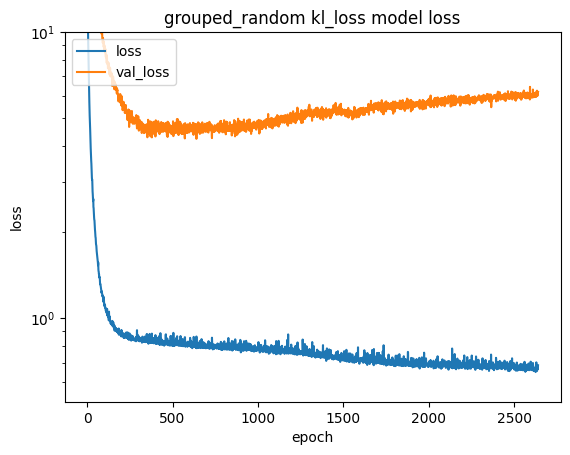

Val loss: 4.238080978393555
Train loss: 0.8641752004623413
Test loss: 1.3929147720336914
dO18 RMSE: 0.9359185952154787
EXPECTED:
   d18O_cel_mean  d18O_cel_variance
0         27.714           0.461230
1         26.820           0.293950
2         26.686           0.267730
3         26.144           0.555280
4         26.134           0.194530
5         25.576           1.794680
6         25.196           0.410630
7         25.330           0.286467
8         25.882           0.233670
9         24.792           1.982470

PREDICTED:
   d18O_cel_mean  d18O_cel_variance
0      25.500952           0.275772
1      26.270105           0.321005
2      26.339787           0.360848
3      26.236437           0.401474
4      26.171700           0.441728
5      26.033039           0.483749
6      24.946869           0.527454
7      25.756935           0.573997
8      25.655819           0.624186
9      26.502338           0.658509


2023-07-28 02:11:21.136963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [10,14]
	 [[{{node Placeholder/_0}}]]


In [ ]:
grouped_random = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_26_isoscapes_train_random_grouped_ordinary_kriging_linear.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_26_isoscapes_test_random_grouped_ordinary_kriging_linear.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/uc_davis_2023_08_26_isoscapes_validation_random_grouped_ordinary_kriging_linear.csv'),
}

grouped_random_scaled = load_and_scale(grouped_random)
model = train_and_evaluate(grouped_random_scaled, "grouped_random", training_batch_size=3)


### 2) Grouped, fixed

grouped_fixed
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 20)           240         ['input_3[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 20)           420         ['dense_4[0][0]']                
                                                                                                  
 var_output (Dense)             (None, 1)            21          ['dense_5[0][0]']                
                                                                              

<ipython-input-23-9e07bce089ec>:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim((0, 10))


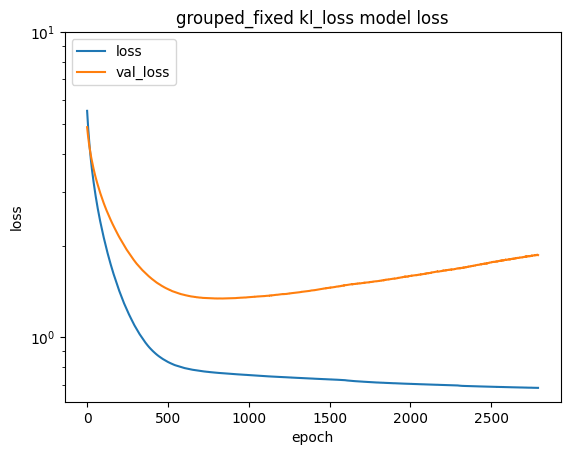

Val loss: 1.3408005237579346
Train loss: 0.7645465731620789
Test loss: 1.1381109952926636
dO18 Test RMSE: 1.396089894424796


dO18 Val RMSE: 1.0934179632593797
EXPECTED:
    d18O_cel_mean  d18O_cel_variance
0       24.042000           0.345970
1       25.240000           0.035950
2       25.782000           0.372220
3       25.076000           0.230280
4       25.966000           0.172480
5       27.434000           0.501030
6       28.156000           0.999030
7       26.836000           0.120880
8       28.180000           0.778250
9       26.834000           0.094930
10      26.644000           0.488430
11      26.772000           0.373370
12      27.684280           1.216389
13      27.403235           0.892280
14      24.777670           0.736571
15      25.551850           0.312355
16      25.115885           0.033519
17      25.987815           5.280825
18      24.132031           0.389042

PREDICTED:
    d18O_cel_mean  d18O_cel_variance
0       25.779707           1.060948
1       25.779707           1.060948
2       25.779707           1.060948
3       25.779707           1.060948
4       25.779707  

In [24]:
grouped_fixed = {
    'TRAIN' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_2023_08_26_isoscapes_train_fixed_grouped_ordinary_kriging_linear.csv'),
    'TEST' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_2023_08_26_isoscapes_test_fixed_grouped_ordinary_kriging_linear.csv'),
    'VALIDATION' : os.path.join(FP_ROOT, 'amazon_sample_data/kriging_ensemble_experiment/uc_davis_2023_08_26_isoscapes_validation_fixed_grouped_ordinary_kriging_linear.csv'),
}

grouped_fixed_scaled = load_and_scale(grouped_fixed)
model = train_and_evaluate(grouped_fixed_scaled, "grouped_fixed", training_batch_size=3)